In [ ]:
# TODO
# cross validation
# Logging
# save fig as image file
# save model and load
# change to function(predict_to_csv)
# seperate .py

In [ ]:
''' 
  1. dir 설정
  2. log 설정(model & optimizer, performance, params, time)
  3. EDA(생략 가능)
  4. DATA 전처리
    - class 생성
    - resize, totensor 등
    - DataSet
      init: dir 설정
      len: data 갯수 반환
      getitem: input: index, return: data(img), label
  5. model, optimizer, loss_fn, scheudler, metric 등 생성
  6. trainer(train_one_epoch, evaluate_one_epoch)
  7. inference(test data)
'''

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive')
FOLDERNAME = 'ai_korea/img_classification/trash'

%cd /content/drive/My\ Drive/$FOLDERNAME
sys.path.append('/content/drive/My Drive'.format(FOLDERNAME))

Mounted at /content/drive
/content/drive/My Drive/ai_korea/img_classification/trash


In [ ]:
import cv2
import os

import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import gc
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.optim as optim

## directory 설정

In [ ]:
data_dir = os.path.join(os.getcwd(), 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## Dataset

In [ ]:
class TrashDataset(Dataset):
  def __init__(self, img_path, csv_path, category_map, transform = None):
    self.img_path = img_path
    self.img_names = os.listdir(self.img_path)
    self.csv = pd.read_csv(csv_path)
    self.category_map = category_map
    self.transform = transform

    if transform is not None:
      self.transform = transform

  def __len__(self):
    return len(self.csv)

  def __getitem__(self, index):
    file_name = self.csv['file_name'][index]
    category = self.csv['category'][index]
    category_num = torch.tensor([self.category_map[category]])
    img = cv2.imread(os.path.join(self.img_path, file_name))
    if self.transform is not None:
      img = self.transform(img)
    
    return img, category_num

In [ ]:
img_path = os.path.join(train_dir, 'images')
csv_path = os.path.join(train_dir, 'train.csv')

train_csv = pd.read_csv(csv_path)
categories = train_csv['category'].unique().tolist()
n_categories = len(categories)
category_map = {category: i for i, category in zip(range(n_categories), categories)}
idx_to_category = {i: category for i, category in zip(range(n_categories), categories)}

transform = {}
transform['train'] = T.Compose([T.ToTensor(), 
                               T.Resize((224, 224))])
transform['test'] = T.Compose([T.ToTensor(),
                              T.Resize((224, 224))])
train_dataset = TrashDataset(img_path, csv_path, category_map, transform['train'])

In [ ]:
# from collections import defaultdict


# img_names = os.listdir(img_path)
# data_dict = defaultdict(list)
# for i in range(128):
#   # img = Image.open(os.path.join(img_path, img_names[i]))
#   img = cv2.imread(os.path.join(img_path, img_names[i]))
#   category_name = train_csv[train_csv['file_name'] == img_names[i]]['category']
#   data_dict['category'].extend(category_name)
#   data_dict['data'].extend(transform['train'](img))
  

## Show some images and labels
 - to check roughly whether each of images and labels properly matches or not


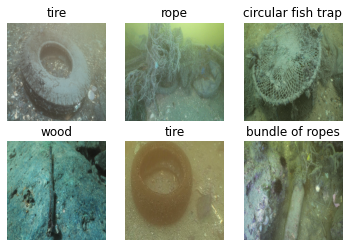

In [ ]:
def show_dataset(dataset):
  for i in range(6):
    img, category_num = random.choice(dataset)
    category = idx_to_category[category_num.item()]
    plt.subplot(2, 3, i+1)
    plt.title(category)
    plt.imshow(np.array(img.permute(1, 2, 0)))
    plt.axis('off')
  plt.show()
show_dataset(train_dataset)

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_channels, H, W, n_categories):
    super().__init__()
    D = in_channels * H * W
    self.mlp = nn.Sequential(
        nn.Flatten(),
        nn.Linear(D, 100),
        nn.ReLU(),
        nn.Linear(100, 400),
        nn.ReLU(),
        nn.Linear(400, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, n_categories)
    )
    
  def forward(self, x):
    return self.mlp(x)

In [ ]:
model = MLP(3, 224, 224, n_categories)
x = torch.randn((1, 3, 224, 224))
with torch.no_grad():
  out = model(x)
  print(out.size())

torch.Size([1, 10])


In [ ]:
# data split, loss_function, etc

mini_train_dset, _ = torch.utils.data.random_split(train_dataset, [0.01, 0.99])
mini_val_dset, mini_train_dset = torch.utils.data.random_split(mini_train_dset, [0.2, 0.8]) # len(mini_train_dset) = 15, len(mini_train_dset) = 57
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0009200258996031122, weight_decay = 0.012915838982796628)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# make data loader
mini_train_dl = DataLoader(mini_train_dset, batch_size = 64)
mini_val_dl = DataLoader(mini_val_dset, batch_size = 64)

In [ ]:
class Trainer:
  def __init__(self, 
               model, 
               train_dl, 
               val_dl, 
               loss_fn, 
               optimizer, 
               device = None, 
               print_every = 10, 
               tolerance_interval = 1e-5, 
               tolerance_ratio = 0.9):
    self.model = model
    self.train_dl = train_dl
    self.val_dl = val_dl
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.train_loss_hist, self.val_loss_hist = list(), list()
    self.train_acc_hist, self.val_acc_hist = list(), list()
    self.f1_scores = list()
    self.print_every = print_every
    self.tolerance_interval, self.tolerance_ratio = tolerance_interval, tolerance_ratio
    self.early_stop = False
    self.now_loss = float('inf')
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device


  def train_epoch(self):
    model = self.model.to(self.device)
    model.train()
    optimizer, loss_fn  = self.optimizer, self.loss_fn.to(self.device)
    n_data = len(self.train_dl.dataset)
    batch_size = self.train_dl.batch_size
    n_corrects = 0
    cum_n_data = 0
    print('[training]')
    for i, (data, target) in enumerate(self.train_dl):
      data, target = data.to(self.device), target.to(self.device)
      target = target.squeeze(dim = -1)

      logits = model(data)
      loss = loss_fn(logits, target)
      self.train_loss_hist.append(loss.item())

      if (i+1) % self.tolerance_interval == 0:
        if loss.item() / self.train_loss_hist[-(self.tolerance_interval)] > self.tolerance_ratio:
          self.early_stop = True
          print(loss.item())
          print('*' * 20, 'ealry stop', '*' * 20)
          break

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      preds = torch.argmax(logits, dim = -1)
      n_corrects += torch.sum(preds == target).item()

      cum_n_data += len(target)
      if i % self.print_every == 0:
        print(f'{cum_n_data}/{n_data} loss: {self.train_loss_hist[-1]}')
    self.train_acc_hist.append(n_corrects / n_data)
    print(f"train accuracy: {self.train_acc_hist[-1]}")
  def eval_epoch(self):
    if self.early_stop:
      return

    model = self.model.to(self.device)
    model.eval()
    n_data = len(self.val_dl.dataset)
    batch_size = self.val_dl.batch_size
    loss_fn = self.loss_fn
    n_corrects = 0
    cum_n_data = 0
    
    print('[evaluation]')
    for i, (data, target) in enumerate(self.val_dl):
      with torch.no_grad():
        

        data, target = data.to(self.device), target.to(self.device)
        target = target.squeeze(dim = -1)
        logits = model(data)
        
        loss = loss_fn(logits, target)
        self.val_loss_hist.append(loss.item())
        
        preds = torch.argmax(logits, dim = -1)
        n_corrects += torch.sum(preds == target).item()
        self.f1_scores.append(f1_score(target.cpu(), preds.cpu(), average='macro'))

        cum_n_data += len(target)
      if i % self.print_every == 0 :
        print(f'{cum_n_data} / {n_data}, loss: {self.val_loss_hist[-1]}')
    self.val_acc_hist.append(n_corrects / n_data)
    print(f"average accuracy: {self.val_acc_hist[-1]}")

  '''
  def _early_stopper(self):
    if self.now_loss < self.train_loss_hist[-1]:
      self.tolerance += 1
    if self.tolerance >= self.max_tolerance:
      return True
    self.now_loss = self.train_loss_hist[-1]
  '''


In [ ]:
trainer = Trainer(model, mini_train_dl, mini_val_dl, loss_fn, optimizer, device)

In [ ]:
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
  trainer.train_epoch()
  trainer.eval_epoch()

In [ ]:
def plot_metrics(trainer):
  if type(trainer) != dict:
    opt_params = trainer.optimizer.param_groups[0]
    opt_name = trainer.optimizer.__class__.__name__
    trainer = {(opt_name, opt_params['lr'], opt_params['weight_decay']): trainer}
  
  n_keys = len(trainer.keys())
  fig, ax = plt.subplots(3, 1, figsize = (15, 14))
  for k, trainer_ in trainer.items():
    (opt_name, lr, decay) = k
    ax[0].plot(trainer_.train_loss_hist, '-o', label = f'opt: {opt_name}, lr: {lr:.5f}, decay: {decay:.4f}')
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('train losses')
    ax[0].grid(linestyle='--', linewidth=0.5)
    ax[0].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    ax[1].plot(trainer_.train_acc_hist, '-o', label = f'opt: {opt_name}, lr: {lr:.5f}, decay: {decay:.4f}')
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('train accuracies')
    ax[1].grid(linestyle='--', linewidth=0.5)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    ax[2].plot(trainer_.val_acc_hist, '-o', label = f'opt: {opt_name}, lr: {lr:.5f}, decay: {decay:.4f}')
    ax[2].legend(loc = 'lower right')
    ax[2].set_title('validation accuracies')
    ax[2].grid(linestyle='--', linewidth=0.5)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Accuracy')

  plt.show()

  # cwd = os.getcwd()
  # plots_path = os.path.join(cwd, 'plots')
  # os.mkdir(plots_path, exist_ok=True)
  # fig.savefig(f'plots/plot_metrics')

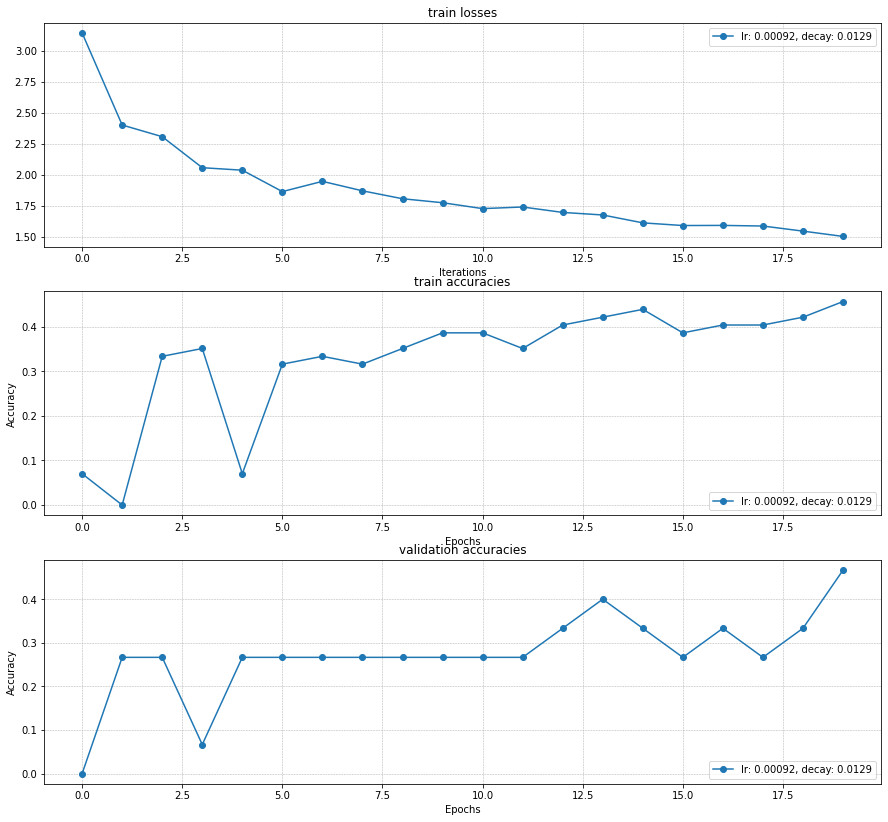

In [ ]:
plot_metrics(trainer)

In [ ]:
print(f'maximum accuracy in training data: {max(trainer.train_acc_hist)}')
print(f'maximum accuracy in validation data: {max(trainer.val_acc_hist)}')

maximum accuracy in training data: 0.45614035087719296
maximum accuracy in validation data: 0.4666666666666667


## Fine Tuning

1. load pretrained model <br>
2. freeze the parameters(requires_grad = False) <br>
3. initialize the classifier<br>


In [ ]:
from torchvision import models

model = None
pretrained_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# if you can't load pretrained_model above, try below

# from torch import models
# weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
# pretrained_model = models.efficientnet_b0(weights = weights)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
# freeze the parameters of pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

In [ ]:
# problem: the output.size() is (1, 1000) because the model is trained on n_categories is 1000 of image classification
# so we have to change the last linear layer 
# from nn.Linear(in_features, 1000) -> nn.Linear(in_features, n_categories) (in our case n_categories is 10)

x = torch.randn((1, 3, 224, 224))
with torch.no_grad():
  out = pretrained_model(x)
  print(out.size())

torch.Size([1, 1000])


In [ ]:
in_features= pretrained_model.classifier.fc.in_features
pretrained_model.classifier.fc = nn.Linear(in_features, n_categories)

x = torch.randn((1, 3, 224, 224))
with torch.no_grad():
  print(pretrained_model(x).size())

torch.Size([1, 10])


In [ ]:
train_dset, val_dset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dl = DataLoader(train_dset, batch_size = 64, shuffle = True)
val_dl = DataLoader(val_dset, batch_size = 64, shuffle = True)

In [ ]:
_, small_dset = torch.utils.data.random_split(train_dataset, [0.7, 0.3])
small_train_dset, small_val_dset = torch.utils.data.random_split(small_dset, [0.8, 0.2])
small_train_dl = DataLoader(small_train_dset, batch_size = 64, shuffle = True)
small_val_dl = DataLoader(small_val_dset, batch_size = 64, shuffle = True)

In [ ]:
# hyper parameter tuning

def get_opt(name):
  return getattr(optim, name)

def random_search(pretrained_model, train_dl, val_dl, loss_fn, n_search, tolerance_interval = 1e-5, **kwargs):
  NUM_EPOCHS = 1
  optimizers = ['Adagrad', 'Adam', 'RMSprop', 'SGD'] 
  trainers = dict()
  candidate, min_val_loss = None, float('inf')
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for _ in range(n_search):
    
    gc.collect() # garbage collect
    torch.cuda.empty_cache() 
    model = copy.deepcopy(pretrained_model).to(device) # you should model moves to device before init optimizer!!! ref:https://github.com/pytorch/pytorch/issues/7321

    opt = kwargs.pop('optimizer', random.choice(optimizers))
    lr = kwargs.pop('lr', 10**np.random.uniform(-5, -1))
    weight_decay = kwargs.pop('weight_decay', 10**np.random.uniform(-2, -1.2))

    '''
    naive choice of optimizer
    if opt == 'Adagrad':
      optimizer = optim.Adagrad(model.parameters(), lr = lr, weight_decay = weight_decay)
      print(optimizer.state_dict())
    elif opt == 'Adam':
      optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    elif opt == 'RMSprop':
      optimizer = optim.RMSprop(model.parameters(), lr = lr, weight_decay = weight_decay)
    elif opt == 'SGD':
      optimizer = optim.SGD(model.parameters(), lr, weight_decay = weight_decay)
    else:
      print(f'optimizer shoule be among in {optimizers}')
      break

    '''
    optimizer = get_opt(opt)(model.parameters(), lr = lr, weight_decay = weight_decay) # ref: https://discuss.pytorch.org/t/function-for-picking-an-optimizer/106798
    
    trainer = Trainer(model, train_dl, val_dl, loss_fn, optimizer, device, tolerance_interval = tolerance_interval)
    trainers[(optimizer.__class__.__name__, lr, weight_decay)] = trainer

    print(f'optimizer: {opt}, lr: {lr}, weight_decay: {weight_decay}')
    
    for epoch in range(NUM_EPOCHS):
      print('')
      print(f'Epoch: {epoch+1} / {NUM_EPOCHS}')
      trainer.train_epoch()
      trainer.eval_epoch()
      if trainer.early_stop:
        break
      n_data = len(trainer.val_dl.dataset)

      val_loss = np.mean(np.array(trainer.val_loss_hist[epoch*n_data: (epoch+1)*n_data]))
      if val_loss < min_val_loss:
        candidate = copy.deepcopy(model) 
        min_val_loss = val_loss
    model = None
  return candidate, trainers

# n_search = 5

# NUM_EPOCHS = 1

# for _ in range(n_search):
#   lr = 10**np.random.uniform(-5, -1)
#   weight_decay = 10**np.random.uniform(-2, -1.4)
#   gc.collect() # garbage collect
#   torch.cuda.empty_cache() 
  
#   model = copy.deepcopy(pretrained_model)
#   optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
#   trainer = Trainer(model, train_dl, val_dl, loss_fn, optimizer, device)
#   trainers[(lr, weight_decay)] = trainer

#   print('*'*20 + f' learning rate: {lr}, weight_decay: {weight_decay} ' + '*' * 20)
  
#   for epoch in range(NUM_EPOCHS):
#     trainer.train_epoch()
#     trainer.eval_epoch()

#   model = None
candidate, trainers = random_search(pretrained_model, small_train_dl, small_val_dl, loss_fn, 7, tolerance_interval = 10)

optimizer: Adam, lr: 0.0003203691024466975, weight_decay: 0.01141750041321689
Epoch: 1 / 1
[training]
64/1725 loss: 2.337718963623047
704/1725 loss: 2.1130151748657227
1.9190611839294434
******************** ealry stop ********************
train accuracy: 0.20405797101449274
optimizer: Adam, lr: 0.011919593111953439, weight_decay: 0.024498660386036753
Epoch: 1 / 1
[training]
64/1725 loss: 2.29243540763855
704/1725 loss: 0.7060496807098389
1344/1725 loss: 0.5347956418991089
train accuracy: 0.7344927536231884
[evaluation]
64 / 431, loss: 1.3016908168792725
average accuracy: 0.6867749419953596
optimizer: Adam, lr: 0.042300730639437345, weight_decay: 0.04274724253292578
Epoch: 1 / 1
[training]
64/1725 loss: 2.304889440536499
704/1725 loss: 0.9793447852134705
1344/1725 loss: 1.0087027549743652
train accuracy: 0.6765217391304348
[evaluation]
64 / 431, loss: 1.0160105228424072
average accuracy: 0.6380510440835266
optimizer: Adam, lr: 0.013073272989608161, weight_decay: 0.04987131832882462
Epo

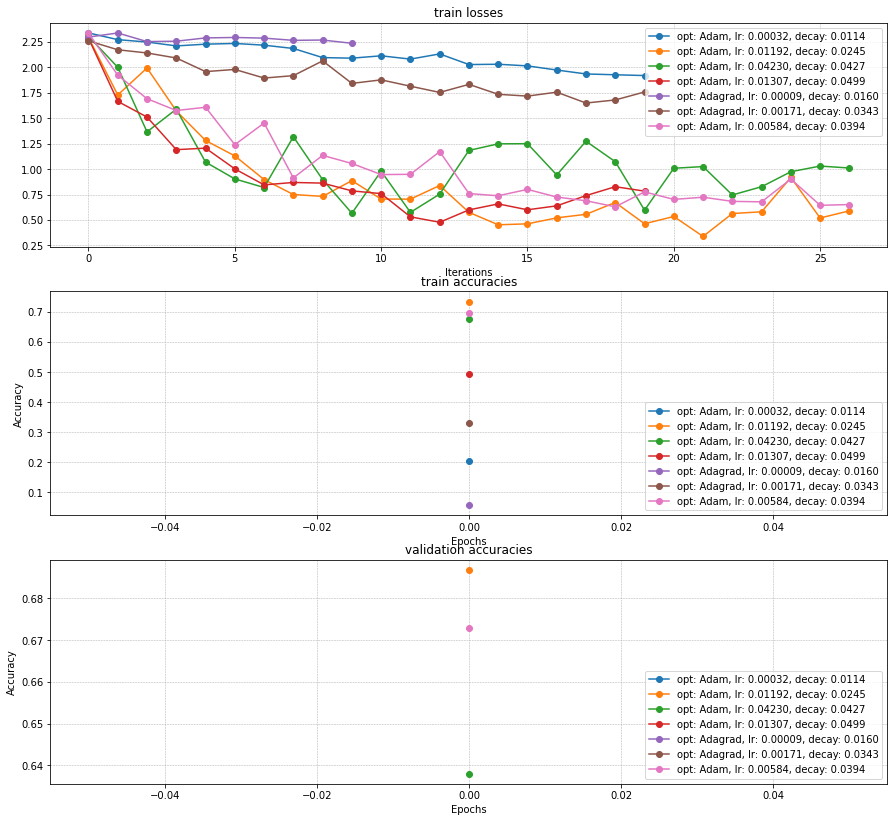

In [ ]:
plot_metrics(trainers)

In [ ]:
def get_k_hyper_params(trainers, k, metric = 'val_acc'):
  top_k =[float('-inf')]
  param_map = dict()
  for params, trainer_ in trainers.items():
    if metric == 'val_acc':
      now = max(trainer_.val_acc_hist, default=0)
    elif metric == 'f1_score':
      now = max(trainer_.f1_scores, default=0)
    elif metric == 'train_acc':
      now = max(trainer_.train_acc_hist, default=0)

    if now > top_k[-1] or len(top_k) < k:
      param_map[now] = params
      top_k.append(now)
      top_k.sort(reverse = True)
      top_k, left_over = top_k[:k], top_k[k:]
      if len(left_over) == 0:
        continue

      left_over = left_over[0]
      if left_over in param_map.keys():
        del param_map[left_over]
  print(f'metric: {metric}, hyper params: (optimizer, learning rate, weight decay)')
  return list(sorted(param_map.items(), reverse = True, key = lambda key: key))

In [ ]:
get_k_hyper_params(trainers, k=5)

metric: val_acc, hyper params: (optimizer, learning rate, weight decay)


[(0.6867749419953596, ('Adam', 0.011919593111953439, 0.024498660386036753)),
 (0.6728538283062645, ('Adam', 0.0058357179042852324, 0.03944794563001747)),
 (0.6380510440835266, ('Adam', 0.042300730639437345, 0.04274724253292578))]

In [ ]:
opt_name, lr, weight_decay = get_k_hyper_params(trainers, k = 5, metric = 'f1_score')[0][1]

metric: f1_score, hyper params: (optimizer, learning rate, weight decay)


In [ ]:
model = pretrained_model.to(device)
optimizer = get_opt(opt_name)(model.parameters(), lr = lr, weight_decay = weight_decay)
NUM_EPOCHS = 10
trainer = Trainer(model, train_dl, val_dl, loss_fn, optimizer, device)
best_model, best_acc = None, float('-inf')

for epoch in range(NUM_EPOCHS):
  trainer.train_epoch()
  trainer.eval_epoch()
  if best_acc < trainer.val_acc_hist[-1]:
    best_model = copy.deepcopy(model)
    best_acc = trainer.val_acc_hist[-1]

# it took about 50 minitues using colab gpu

[training]
64/5750 loss: 2.3197925090789795
704/5750 loss: 0.7412515878677368
1344/5750 loss: 0.6415168046951294
1984/5750 loss: 0.3520432412624359
2624/5750 loss: 0.5646082162857056
3264/5750 loss: 0.6596661806106567
3904/5750 loss: 0.5883357524871826
4544/5750 loss: 0.6084035038948059
5184/5750 loss: 0.5777379870414734
train accuracy: 0.8048695652173913
[evaluation]
64 / 1437, loss: 1.1115552186965942
704 / 1437, loss: 1.1132533550262451
1344 / 1437, loss: 1.0214600563049316
average accuracy: 0.7661795407098121
[training]
64/5750 loss: 0.5477003455162048
704/5750 loss: 0.5605533719062805
1344/5750 loss: 0.5858131647109985
1984/5750 loss: 0.5484049320220947
2624/5750 loss: 0.5898818373680115
3264/5750 loss: 0.483521044254303
3904/5750 loss: 0.5989540219306946
4544/5750 loss: 0.5467298030853271
5184/5750 loss: 0.5756359100341797
train accuracy: 0.8304347826086956
[evaluation]
64 / 1437, loss: 1.1095280647277832
704 / 1437, loss: 0.8994605541229248
1344 / 1437, loss: 0.8049616813659668


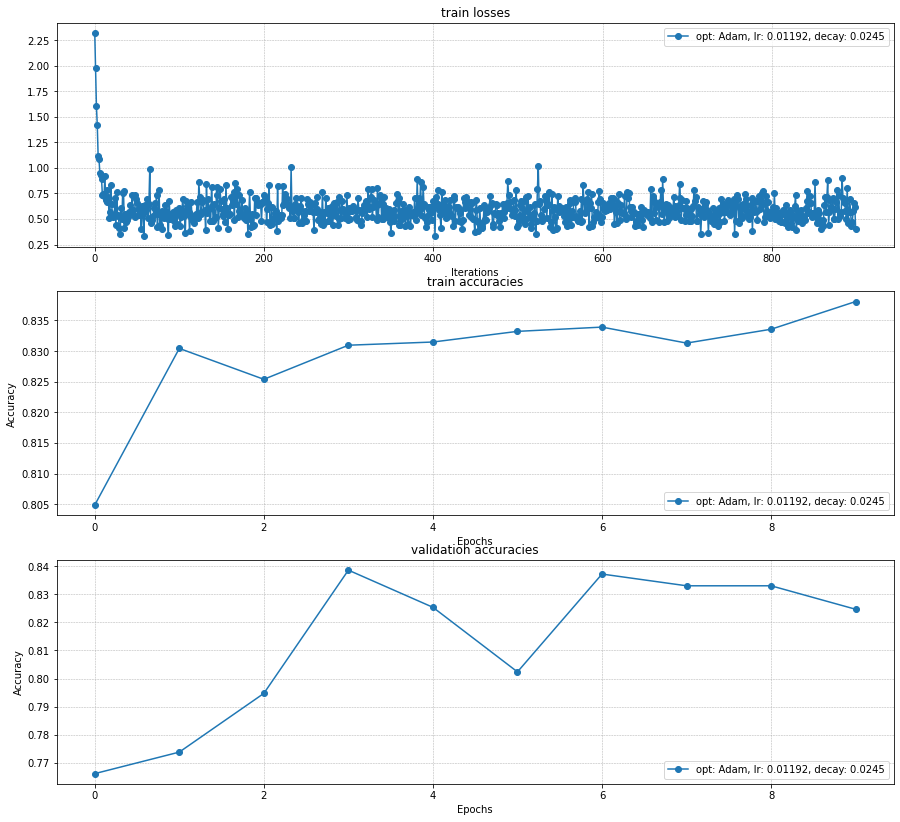

In [ ]:
plot_metrics(trainer)

## submit

In [ ]:
class TrashTestDataset(Dataset):
  def __init__(self, path, transform = None):
    self.file_names = os.listdir(path)
    self.path = path
    self.transform = transform
    
  def __len__(self):
    return len(self.file_names)

  def __getitem__(self, index):
    file_name = self.file_names[index]
    img = cv2.imread(os.path.join(self.path, file_name))

    if self.transform is not None:
      img = self.transform(img)

    return img, file_name


test_data_set = TrashTestDataset(os.path.join(test_dir, 'images'), transform['test'])


In [ ]:
test_dl = DataLoader(test_data_set, batch_size = 128)

In [ ]:
submission_path = None

pred_list = []
file_list = []
with torch.no_grad():
  for data, file_names in test_dl:
    best_model.eval() # I mistakenly omit to move the model eval mode. So, you shouldn't...
    data = data.to(device)
    logits = best_model(data)
    preds = torch.argmax(logits, 1)
    pred_list.extend(preds.cpu().tolist())
    file_list.extend(file_names)

In [ ]:
pred_list = list(map(lambda x: idx_to_category[x], pred_list))
pred_df = pd.DataFrame({'file_name': file_list,
                        'category': pred_list})

In [ ]:
pred_df.head()

,file_name,category
0,5dYbR0q3JfKiY6Z.jpg,fish net
1,MLLZk6uujsW5yQh.jpg,circular fish trap
2,HfV3OXbRCP48gF6.jpg,fish net
3,C2USZh5oO5SQAqc.jpg,tire
4,WMriTbkmzxt1FKm.jpg,circular fish trap


In [ ]:
SAVE_PATH = os.path.join(os.getcwd(), 'submission.csv')
pred_df.to_csv(SAVE_PATH, index=False)

## result

<p align="center">
<img src="https://raw.githubusercontent.com/withAnewWorld/ai_korea/master/results/trash_result.png">
</p>